# Genetic Algorithm Lab

This notebook is meant to guide you in your first full program for the Artificial Intelligence course. Instructions and convenience classes are prepared for you, but you will need to fill in various code cells in order for the notebook to be fully-functioning. These code cells are marked with #TODO comments. Feel free to modify any other code in this notebook as well. In particular, wherever you see #SUGGESTION comments, you may want to explore alternatives (not compulsory).

The problem to be solved in this lab is the Travelling Salesman Problem. More details on this problem are provided in your lab sheet.

## Imports

In [16]:
%matplotlib inline
# Put the imports you need here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import csv
from itertools import groupby
from pprint import pprint as print # pretty printing, easier to read but takes more room

## Convenience Classes

The 'City' class allows us to easily measure distance between cities. A list of cities is called a route, and will be our chromosome for this genetic algorithm.

In [17]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        #SUGGESTION - What if we wanted to use a different distance
        # metric? Would that make sense for this problem?
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

The 'Fitness' class helps to calculate both the distance and the fitness of a route (list of City instances).

In [18]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = None
        self.fitness = None
    
    def routeDistance(self):
        if self.distance == None:
            pathDistance = 0.0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i+1 < len(self.route):
                    toCity = self.route[i+1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == None:
            self.fitness = 1 / float(self.routeDistance())
            #SUGGESTION - Is the scaling an issue with this method
            # of defining fitness? Would negative distance make more
            # sense (obviously with properly defined selection functions)
        return self.fitness

## Initialization Step

Initialization starts with a large **population** of randomly generated chromosomes. We will use 3 functions. The first one generates a list of cities from a file.

In [19]:
def genCityList(filename):
    cityList = []
    lines = [line.strip() for line in open(filename)]
    for line in lines:
        data = line.split()
        cityList.append(City(x=float(data[1]), y=float(data[2])))
    return cityList

The second function generates a random route (chromosome) from a list of City instances.

In [20]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

The third function repeatedly calls the second function to create an initial population (list of routes).

In [21]:
def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    #SUGGESTION - Could population be 'seeded' with known good routes?
    # In other words, would heuristic initialization help?
    return population

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

cityList = genCityList('TSPdata/tsp-case00.txt')
print(cityList)

cityList = genCityList('tsp-case01.txt')
population = initialPopulation(3, cityList)
print(population)

In [22]:
def rankRoutes(population):
    popFitness = [(population.index(i), Fitness(i).routeFitness()) for i in population]
    ranked = sorted(popFitness, key=lambda x: x[1], reverse=True)
    return [i[0] for i in ranked]
    

## Selection

Parent selection is the primary form of selection, and is used to create a mating pool.

def parentSelection(population, poolSize=None):
    
    if poolSize == None:
        poolSize = len(population)
        
    matingPool = []
    
    max = sum([Fitness(i).routeFitness() for i in population])
    for chromosome in population:
        pick = random.uniform(0, max)
        current = 0
        current += Fitness(chromosome).routeFitness()
        if current > pick:
            matingPool.append(chromosome)
    return matingPool

In [23]:
def parentSelection(population, poolSize=None):
    
    if poolSize == None:
        poolSize = len(population)
        
    matingPool = []
    
    while len(matingPool) < poolSize:
        participants = random.sample(population, int(poolSize * 0.2))
        ranked = rankRoutes(participants)
        matingPool.append(participants[ranked[0]])
    
    return matingPool

Another form of selection is survivor selection, which is used to ensure certain individuals (normally high fitness ones) survive to the next generation.

In [24]:
def survivorSelection(population, eliteSize):
    """
    This function returns a list of length eliteSize (the selected
    City instances which will be preserved)
    """
    popRanked = rankRoutes(population)
    elites = []
    
    for i in range(eliteSize):
        elites.append(population[popRanked[i]])
    
    return elites

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

population = initialPopulation(4, genCityList('TSPdata/tsp-case00.txt'))
matingpool = parentSelection(population, 3)
print('Initial population')
print(population)
print('Mating pool')
print(matingpool)

population = initialPopulation(4, genCityList('TSPdata/tsp-case00.txt'))
elites = survivorSelection(population, 1)
print('Initial population')
print(population)
print('Selected elites')
print(elites)

## Crossover

The crossover function combines two parents in such a way that their children inherit some of each parent's characteristics. In the case of TSP, you will need to use crossover methods such as Davis' Order Crossover (other examples are listed in the lecture slides).

def crossover(parent1, parent2):
    
    #Davis order crossover
    
    selectedGeneIndex = sorted(random.sample(list(range(len(parent1))), int(len(parent1)/2)))
    selectedParent1Gene = parent1[selectedGeneIndex[0]: selectedGeneIndex[1] + 1]
    selectedParent2Gene = parent2[selectedGeneIndex[0]: selectedGeneIndex[1] + 1]
    
    child1 = [None] * len(parent1)
    child2 = [None] * len(parent1)
        
    for i in range(len(parent2)):
        if parent2[i] not in selectedParent1Gene:
            child1[i] = parent2[i]
        if parent1[i] not in selectedParent2Gene:
            child2[i] = parent1[i]

    for i in range(len(child1)):
        if child1[i] is None:
            child1[i] = selectedParent1Gene.pop(0)
        if child2[i] is None:
            child2[i] = selectedParent2Gene.pop(0)
    
    return child1, child2
    

In [25]:
def crossover(parent1, parent2):
    
    #Order one crossover
    
    child1 = [None] * len(parent1)
    child2 = [None] * len(parent1)
    
    startEndIndex = sorted(random.sample(list(range(len(parent1))), 2))
    
    parent1Selected = parent1[startEndIndex[0]: startEndIndex[1] + 1]
    parent2Selected = parent2[startEndIndex[0]: startEndIndex[1] + 1]
    
    child1[startEndIndex[0]: startEndIndex[1] + 1] = parent1Selected
    child2[startEndIndex[0]: startEndIndex[1] + 1] = parent2Selected
    
    newParent2 = parent2[startEndIndex[1] + 1:] + parent2[0: startEndIndex[1] + 1]
    newParent2 = [i for i in newParent2 if i not in parent1Selected]
    
    newParent1 = parent1[startEndIndex[1] + 1:] + parent1[0: startEndIndex[1] + 1]
    newParent1 = [i for i in newParent1 if i not in parent2Selected]
    
    for i in range(len(child1)):
        if child1[i] is None:
            child1[i] = newParent2.pop(0)
            
    for i in range(len(child2)):
        if child2[i] is None:
            child2[i] = newParent1.pop(0)
        
                    
    return child1, child2

Crossover should be run on pairs from the mating pool to produce a new generation (of the same size).

In [26]:
def breedPopulation(matingpool):
    children = []
    
    for i in range(1, len(matingpool), 2):
        child1, child2 = crossover(matingpool[i-1], matingpool[i])
        children.append(child1)
        children.append(child2)
    #SUGGESTION - would randomly choosing parents from matingpool make
    # a difference compared to just choosing them in order? Wouldn't be
    # too hard to test that, would it?
    
    return children

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

population = initialPopulation(2, genCityList('TSPdata/tsp-case00.txt'))
parent1, parent2 = population
child1, child2 = crossover(parent1, parent2)
print('Parents')
print(parent1)
print(parent2)
print('Children')
print(child1)
print(child2)

## Mutation

Mutations are small random changes which maintain/introduce diversity. By necessity, mutations must occur at low probability and avoid changing everything in a chromosome. As with crossover, mutation in TSP must respect the constraint that every City occurs exactly once in the Route.

def mutate(route, mutationProbability):

    #Swap
    
    mutatedRoute = route[:]
    if random.random() < mutationProbability:
        swapGenes = random.sample(list(range(len(route))), 2)
        temp = mutatedRoute[swapGenes[0]]
        mutatedRoute[swapGenes[0]] = mutatedRoute[swapGenes[1]]
        mutatedRoute[swapGenes[1]] = temp
        
    return mutatedRoute


In [27]:
def mutate(route, mutationProbability):
    
    #Scramble
    
    mutatedRoute = route[:]
    if random.random() < mutationProbability:
        subsetIndex = sorted(random.sample(list(range(len(mutatedRoute))), 2))
        subset = mutatedRoute[subsetIndex[0]: subsetIndex[1] + 1]
        scrambled = random.sample(subset, len(subset))
        
        for i in range(subsetIndex[0], subsetIndex[1] + 1):
            mutatedRoute[i] = scrambled.pop(0)
    
    return mutatedRoute

The mutate function needs to be run over the entire population, obviously.

In [28]:
def mutation(population, mutationProbability):
    mutatedPopulation = []
    for i in range(0, len(population)):
        mutatedIndividual = mutate(population[i], mutationProbability)
        mutatedPopulation.append(mutatedIndividual)
    return mutatedPopulation

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

route = genCityList('TSPdata/tsp-case00.txt')
mutated = mutate(route, 1)  # Give a pretty high chance for mutation
print('Original route')
print(route)
print('Mutated route')
print(mutated)

## Running One Generation

Now that we have (almost) all our component functions in place, let's call them altogether.

In [29]:
def oneGeneration(population, eliteSize, mutationProbability):
    
    # First we preserve the elites
    elites = survivorSelection(population, eliteSize)
    
    # Then we calculate what our mating pool size should be and generate
    # the mating pool
    poolSize = len(population) - eliteSize
    matingpool = parentSelection(population, poolSize)
    #SUGGESTION - What if the elites were removed from the mating pool?
    # Would that help or hurt the genetic algorithm? How would that affect
    # diversity? How would that affect performance/convergence?
    # Then we perform crossover on the mating pool
    children = breedPopulation(matingpool)
    
    # We combine the elites and children into one population
    new_population = elites + children
    
    # We mutate the population
    mutated_population = mutation(new_population, mutationProbability)
    #SUGGESTION - If we do mutation before selection and breeding, does
    # it make any difference?
    
    return mutated_population

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

population = initialPopulation(5, genCityList('TSPdata/tsp-case04.txt'))
eliteSize = 1
mutationProbability = 0.01
new_population = oneGeneration(population, eliteSize, mutationProbability)
print('Initial population')
print(population)
print('New population')
print(new_population)

## Running Genetic Algorithm

The entire genetic algorithm needs to initialize a Route of City instances, then iteratively generate new generations. Take note that, unlike all the cells above, the cell below is NOT a function. Various parameters are set right at the top (you should set them to something reasonable).

'Best distance for initial population: 41616946.45053146'
'Best distance for population in iteration 0: 41421767.06268823'
'Best distance for population in iteration 1: 41340482.37245255'
'Best distance for population in iteration 2: 41259754.46650478'
'Best distance for population in iteration 3: 41184527.47470829'
'Best distance for population in iteration 4: 41040209.1098684'
'Best distance for population in iteration 5: 40971315.67521939'
'Best distance for population in iteration 6: 40891849.92174105'
'Best distance for population in iteration 7: 40835670.58882459'
'Best distance for population in iteration 8: 40765564.07314092'
'Best distance for population in iteration 9: 40728886.352417886'
'Best distance for population in iteration 10: 40713242.81733044'
'Best distance for population in iteration 11: 40669954.17913811'
'Best distance for population in iteration 12: 40645111.47530999'
'Best distance for population in iteration 13: 40637255.628166355'
'Best distance for populati

'Best distance for population in iteration 123: 39197604.967041604'
'Best distance for population in iteration 124: 39190185.088968806'
'Best distance for population in iteration 125: 39176524.739759505'
'Best distance for population in iteration 126: 39136929.107818365'
'Best distance for population in iteration 127: 39129265.64488611'
'Best distance for population in iteration 128: 39126961.62447417'
'Best distance for population in iteration 129: 39117425.16377277'
'Best distance for population in iteration 130: 39103937.54597042'
'Best distance for population in iteration 131: 39097939.785160996'
'Best distance for population in iteration 132: 39088156.66201436'
'Best distance for population in iteration 133: 39080677.82150005'
'Best distance for population in iteration 134: 39064961.80291222'
'Best distance for population in iteration 135: 39044992.77764317'
'Best distance for population in iteration 136: 39041733.52296827'
'Best distance for population in iteration 137: 39038022.

'Best distance for population in iteration 245: 38017139.57604892'
'Best distance for population in iteration 246: 38005660.752195865'
'Best distance for population in iteration 247: 37999123.27062618'
'Best distance for population in iteration 248: 37995230.72997004'
'Best distance for population in iteration 249: 37986288.61509872'
'Best distance for population in iteration 250: 37967872.74178458'
'Best distance for population in iteration 251: 37965429.779218614'
'Best distance for population in iteration 252: 37955673.81621398'
'Best distance for population in iteration 253: 37940702.5505826'
'Best distance for population in iteration 254: 37936474.96252803'
'Best distance for population in iteration 255: 37927791.08357615'
'Best distance for population in iteration 256: 37920155.99667643'
'Best distance for population in iteration 257: 37910667.10280519'
'Best distance for population in iteration 258: 37896623.007307194'
'Best distance for population in iteration 259: 37883089.017

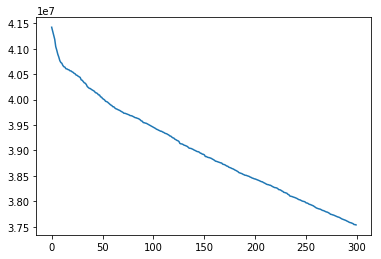

'Overall best distance: 37535196.54236583'
'Time taken: 19728.284106731415 s'


In [30]:
start_time = time.time()
filename = 'TSPdata/tsp-case04.txt'
popSize = 80
eliteSize = int(popSize * 0.2)
mutationProbability = 0.15
iteration_limit = 300

cityList = genCityList(filename)

population = initialPopulation(popSize, cityList)
distances = [Fitness(p).routeDistance() for p in population]
min_dist = min(distances)
dist = []

print("Best distance for initial population: " + str(min_dist))

temp_min_dist = 0
repeatCount = 0

for i in range(iteration_limit):
    population = oneGeneration(population, eliteSize, mutationProbability)
    distances = [Fitness(p).routeDistance() for p in population]
    min_dist = min(distances)
    dist.append(min_dist)
    print("Best distance for population in iteration " + str(i) +
          ": " + str(min_dist))
    if min_dist == temp_min_dist:
        repeatCount += 1
    else:
        temp_min_dist = min_dist
        repeatCount = 0
    if repeatCount > 100:
        break
    
plt.plot(dist)
plt.show()
print("Overall best distance: " + str(min(dist)))

end_time = time.time()
print("Time taken: {} s".format(end_time-start_time))

## Saving the final solution

Once you have completed the lab, you will have to save the final solution to a CSV file for verification. Note that any cheating (identical CSV files, reporting wrong total distances, or modifying coordinates) will result in zero marks awarded for this lab.

In [31]:
filename = 'mysolution.csv'
distances = [Fitness(p).routeDistance() for p in population]
index = np.argmin(distances)
best_route = population[index]
with open(filename, mode='w') as f:
    writer = csv.writer(f, delimiter=' ', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(best_route)):
        writer.writerow([i, best_route[i].x, best_route[i].y])